# Analyze LU+ZGEMM timings - batching on CPU vs GPU

## Test system's hardware

**CPU hardware**

```
$ lscpu
Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 48 bits virtual
  Byte Order:            Little Endian
CPU(s):                  48
  On-line CPU(s) list:   0-47
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) Silver 4214 CPU @ 2.20GHz
    CPU family:          6
    Model:               85
    Thread(s) per core:  2
    Core(s) per socket:  12
    Socket(s):           2
    Stepping:            7
    CPU max MHz:         2200.0000
    CPU min MHz:         1000.0000
    BogoMIPS:            4400.00
```

**GPU hardware**

```
$ nvaccelinfo 

CUDA Driver Version:           12020
NVRM version:                  NVIDIA UNIX x86_64 Kernel Module  535.113.01  Tue Sep 12 19:41:24 UTC 2023

Device Number:                 0
Device Name:                   NVIDIA GeForce RTX 2080 Ti
Device Revision Number:        7.5
Global Memory Size:            11546394624
Number of Multiprocessors:     68
Concurrent Copy and Execution: Yes
Total Constant Memory:         65536
Total Shared Memory per Block: 49152
Registers per Block:           65536
Warp Size:                     32
Maximum Threads per Block:     1024
Maximum Block Dimensions:      1024, 1024, 64
Maximum Grid Dimensions:       2147483647 x 65535 x 65535
Maximum Memory Pitch:          2147483647B
Texture Alignment:             512B
Clock Rate:                    1545 MHz

[4 GPUs in total]
```

### Theoretical peak performance

GPU:
- single RTX 2080 Ti has 420.2 GFLOPS for double precision ([source](https://www.techpowerup.com/gpu-specs/geforce-rtx-2080-ti.c3305))
- all four GPUs together then have 4x420.2 = 1680.8 GFLOPS

CPU:
- In Xeon 4214 has 249.6 GFLOPS peak performance ([source](https://www.intel.com/content/dam/support/us/en/documents/processors/APP-for-Intel-Xeon-Processors.pdf))
- there are 2 CPUs per node: 2x249.6=499.2 GFLOPS per node

## Algorithm of test application

(see `exercise_4_batched_calls/LU` and `exercise_4_batched_calls/LU_GPU`)

0. create large array of matrices (`M` is the number of matrices, `N` the size of each small matrix)
1. run (batched) LU
2. run ZGEMM to check result of previous LU

Compare timings from steps 1, 2 and 1+2 in the following executed on the CPU with varying OpenMP parallelism compared to using a single GPU.

## Timings CPU vs GPU version

### read data - CPU

In [1]:
# for interactive plots uncomment this following line
# %matplotlib widget

import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Openmp, N, M, Batch_size
t = np.loadtxt('times_LU_CPU.csv')



s = list(t.shape)
s[1] += 1
t2 = np.zeros(s)
t2[:,:-1] = t
t2[:,-1] = t[:,-4]/t[:,-2]

Nomp = np.sort(np.array(list(set(t2[:,0])), dtype=int))
N = np.sort(np.array(list(set(t2[:,1])), dtype=int))
M = np.sort(np.array(list(set(t2[:,2])), dtype=int))

tt = t.copy().reshape(len(Nomp), len(N), len(M), -1)


N, M, Nomp

(array([ 16,  32,  64, 128]),
 array([  100,  1000,  5000, 10000, 20000]),
 array([ 1,  2,  4,  8, 16, 32]))

### GPU version

In [3]:
times_GPU = np.loadtxt('times_LU_GPU.csv')
times_GPU = times_GPU.reshape(len(N), len(M), -1)

# compare speedup and timings 

In [4]:
def plot_speedup(iN = 0, iM = 0, show_loop = False, GPU_reference=False):

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.title(f'N={N[iN]:.0f} M={M[iM]:.0f}')
    if show_loop:
        plt.plot(Nomp, tt[:, iN, iM, -4] , label='LU', color='C0', marker='o')
    plt.plot(Nomp, tt[:, iN, iM, -2] , label='LU-batch', color='C1', marker='o')
    if GPU_reference:
        plt.axhline(times_GPU[iN, iM][-2], ls='-', color='k')
        print(f'LU: N={N[iN]:.0f} M={M[iM]:.0f}, time GPU: {times_GPU[iN, iM][-2]}, time CPU: {min(tt[:, iN, iM, -2])}')
    plt.ylabel('runtime (s)')
    plt.xlabel('#OpenMP threads')
    plt.twinx()
    if show_loop:
        plt.plot(Nomp, tt[:, iN, iM, -3] , label='ZGEMM', color='C2', marker='o', ls='--')
    plt.plot(Nomp, tt[:, iN, iM, -1] , label='ZGEMM-batch', color='C3', marker='o', ls='--')
    if GPU_reference:
        plt.axhline(times_GPU[iN, iM][-1], ls='--', color='grey')
        print(f'ZGEMM: N={N[iN]:.0f} M={M[iM]:.0f}, time GPU: {times_GPU[iN, iM][-1]}, time CPU: {min(tt[:, iN, iM, -1])}')
        tg = np.sum(times_GPU[iN, iM][-2:])
        tc = min(tt[:, iN, iM, -1])+min(tt[:, iN, iM, -2])
        print(f'total: N={N[iN]:.0f} M={M[iM]:.0f}, time GPU: {tg}, time CPU: {tc}, GPU/CPU ratio: {np.round(tg/tc, 3)}, CPU/GPU ratio: {np.round(tc/tg, 3)}')
    plt.ylabel('runtime (s) [broken line]')


    plt.subplot(1,2,2)
    plt.title(f'N={N[iN]:.0f} M={M[iM]:.0f}')
    if show_loop:
        plt.plot(Nomp, tt[0, iN, iM, -4]/tt[:, iN, iM, -4] , label='LU', color='C0', marker='o')
    plt.plot(Nomp, tt[0, iN, iM, -2]/tt[:, iN, iM, -2] , label='LU-batch', color='C1', marker='o')
    plt.ylabel('OpenMP speedup')
    plt.xlabel('#OpenMP threads')
    if show_loop:
        plt.plot(Nomp, tt[0, iN, iM, -3]/tt[:, iN, iM, -3] , label='ZGEMM', color='C2', marker='o', ls='--')
    plt.plot(Nomp, tt[0, iN, iM, -1]/tt[:, iN, iM, -1] , label='ZGEMM-batch', color='C3', marker='o', ls='--')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0.35)

    plt.show()

LU: N=16 M=5000, time GPU: 0.018234, time CPU: 0.051978
ZGEMM: N=16 M=5000, time GPU: 0.007565, time CPU: 0.005425
total: N=16 M=5000, time GPU: 0.025799, time CPU: 0.057403, GPU/CPU ratio: 0.449, CPU/GPU ratio: 2.225


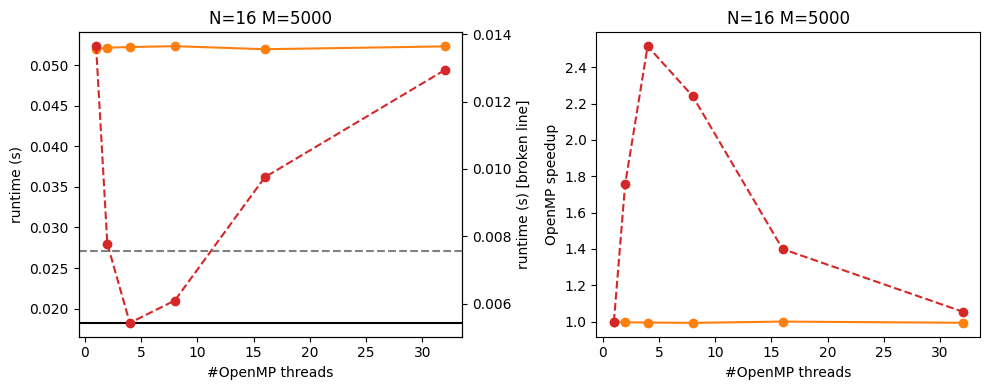

LU: N=32 M=5000, time GPU: 0.037246, time CPU: 0.241215
ZGEMM: N=32 M=5000, time GPU: 0.025888, time CPU: 0.012794
total: N=32 M=5000, time GPU: 0.063134, time CPU: 0.25400900000000004, GPU/CPU ratio: 0.249, CPU/GPU ratio: 4.023


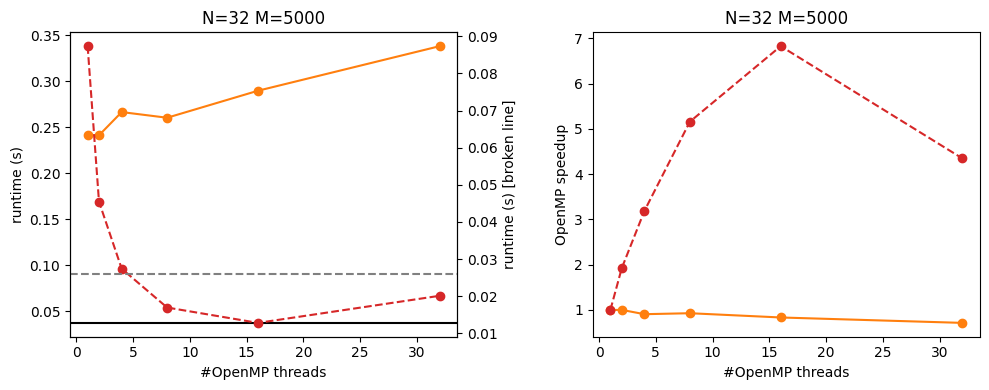

LU: N=64 M=5000, time GPU: 0.150462, time CPU: 0.768727
ZGEMM: N=64 M=5000, time GPU: 0.09764, time CPU: 0.056151
total: N=64 M=5000, time GPU: 0.24810200000000002, time CPU: 0.824878, GPU/CPU ratio: 0.301, CPU/GPU ratio: 3.325


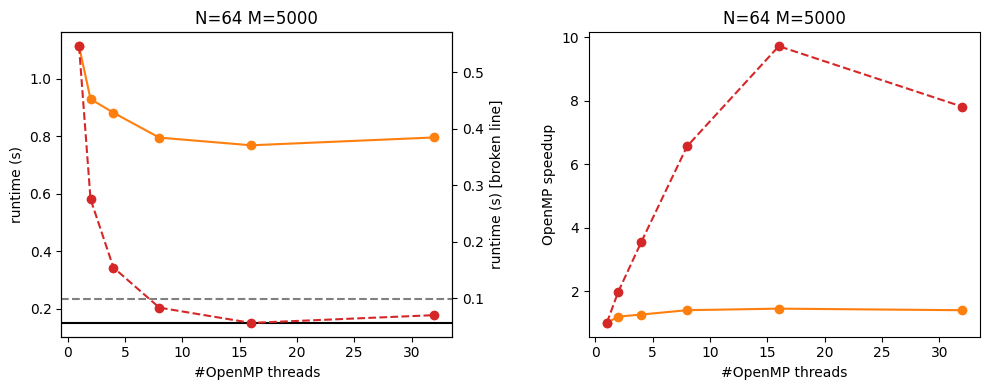

LU: N=128 M=5000, time GPU: 0.747128, time CPU: 3.38328
ZGEMM: N=128 M=5000, time GPU: 0.465353, time CPU: 0.241124
total: N=128 M=5000, time GPU: 1.212481, time CPU: 3.624404, GPU/CPU ratio: 0.335, CPU/GPU ratio: 2.989


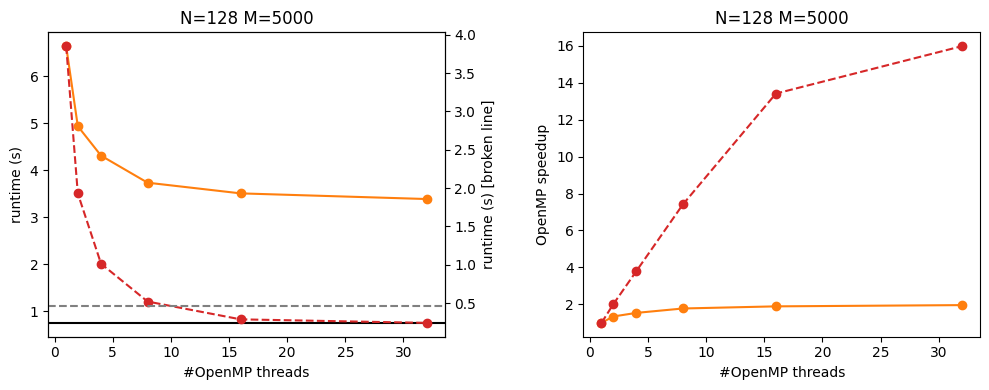

In [11]:
# full lines are for LU (left y-axis)
# broken lines are for ZGEMM (right y axis)
# horizontal lines are from GPU version for LU (full black line) and ZGEMM (grey dashed line)

# select problem size to plot
iM = 2 # 0=100, 1=1000, 2= 5000, 3=10000, 4=20000
show_loop = False
GPU_reference= True

# plot data for different matrix sizes
plot_speedup(iN = 0, iM = iM, show_loop = show_loop, GPU_reference = GPU_reference)
plot_speedup(iN = 1, iM = iM, show_loop = show_loop, GPU_reference = GPU_reference)
plot_speedup(iN = 2, iM = iM, show_loop = show_loop, GPU_reference = GPU_reference)
plot_speedup(iN = 3, iM = iM, show_loop = show_loop, GPU_reference = GPU_reference)